**关于该Notebook**

任务: 以沪深300数据集为例，使用scutquant包完成从原始数据到因子，再到拟合模型和回测的全过程。具体包括:  

(1)、使用**scutquant**(scutquant包下面的一个模块)和**alpha**构造目标值和因子，并自动完成特征工程和数据清洗(包括拆分数据集、填充和去除缺失值、标准化、截断异常值、重采样和降采样、特征筛选和正则化)  

(2)、使用**scutquant**一键建模(以lightgbm为例) 

(3)、使用**scutquant**的ic_ana计算IC、Rank IC和pearson相关系数等指标，并评价模型拟合情况(指标越高越好), IC的计算方式为  
 $$IC(t) = PearsonCorr(predict_{t}, y_{t})$$  
 其中, $PearsonCorr(x, y) = \frac{cov(x,y)}{\sqrt{\sigma_x * \sigma_y}}$, $predict_t$ 为t时刻所有资产的预测值序列(即截面上的预测值), 同理$y_t$ 为截面上的真实值
 
(4)、判断多因子在该模型下是否有效的t检验为 $t = ICIR * \sqrt{\Delta T}$, 其中$ICIR=\frac{\bar{IC}}{\sigma{IC}}$, $\Delta T$为时间间隔(例如测试集的天数). 该方法仅在IC分布为正态分布时成立(ic_ana会输出IC序列的分布图)  

(5)、使用**report**模块查看分组情况(按照每个time_tick的预测情况，对所有资产从高到低分成n组，并计算它们的累计平均收益率)。如果Group1到Group5呈现了明显的单调性(几条曲线交错很少, 且1~5由高到低呈现)则说明因子和模型的选股能力较强，因子较有效.  

5.1、其中, long-short为做多Group1(预测值最高)做空Group5(预测值最低)的累计收益，long-average为做多Group1并无差别做空资产池的累计收益(因为中国股市严格限制做空，因此long-short的收益难以实现，但是可以通过做空股指期货的做法实现套利, 而average对应的就是股指期货)，并给出预测的准确率($predict_{i,t}>=0$且$y_{i,t}>=0$或$predict_{i,t}<0$且$y_{i,t}<0$则为正确，否则为错误)  

(6)、使用**executor**模块执行回测, 需要在字典中写好策略和其它必要的参数, 并使用**report**模块报告回测结果  

In [1]:
# 导入需要用到的库
import pandas as pd
import scutquant.scutquant as q
from scutquant import alpha, report, executor

样例数据集只有基础的价量数据，以面板数据的形式呈现. 当需要额外数据构建因子时(例如需要构建市场因子Rm), 就需要读取supplemental data. 当补充数据为时序数据时，可以使用join_data函数将其合并到数据集中；当补充数据为各个股票的截面数据时，可以使用join_data_by_code按股票代码将数据合并到数据集中

In [2]:
# 读取数据
df = pd.read_csv("D:/Desktop/data.csv")
df["datetime"] = pd.to_datetime(df["datetime"])
df["mean_price"] = df["amount"] / df["vol"] * 10  # 每支股票在当天的交易均价
df.set_index(["datetime", "ts_code"], inplace=True)
df.index.names = ["datetime", "instrument"]
df

open    high     low   close  pre_close  change  \
datetime   instrument                                                      
2006-01-04 000001.SZ     6.13    6.33    6.12    6.28       6.14    0.14   
           000002.SZ     4.40    4.67    4.40    4.66       4.31    0.35   
           000012.SZ     4.70    4.75    4.55    4.70       4.62    0.08   
           000016.SZ     3.52    3.58    3.52    3.57       3.52    0.05   
           000021.SZ     7.99    8.40    7.99    8.32       8.00    0.32   
...                       ...     ...     ...     ...        ...     ...   
2022-12-30 688363.SH   136.00  137.00  131.50  135.28     135.49   -0.21   
           688396.SH    53.06   53.40   52.49   52.65      52.87   -0.22   
           688561.SH    65.49   67.88   64.85   65.77      65.46    0.31   
           688599.SH    63.31   64.56   62.31   63.76      63.20    0.56   
           688981.SH    41.01   41.35   41.01   41.14      40.89    0.25   

                       pct_chg        vol       amount  mean_price  
datetime   instrument                                               
2006-01-04 000001.SZ    2.2800  154450.68   96989.0066    6.279610  
           000002.SZ    8.1200  389310.43  175187.0657    4.499933  
           000012.SZ    1.7300   40399.61   18863.8625    4.669318  
           000016.SZ    1.4200   14426.65    5131.8793    3.557222  
           000021.SZ    4.0000   33526.60   27657.1708    8.249322  
...                        ...        ...          ...         ...  
2022-12-30 688363.SH   -0.1550   29951.60  401624.1560  134.091052  
           688396.SH   -0.4161   23401.54  123568.2880   52.803486  
           688561.SH    0.4736   22567.89  149379.0770   66.190981  
           688599.SH    0.8861  109144.36  695759.9350   63.746760  
           688981.SH    0.6114   60396.11  248594.8820   41.160744  

[1199445 rows x 10 columns]

**关于目标值:** 为了避免数据泄露和其它各种问题，我们构建的目标值应尽量与已知数据无关(即$y_t$无法用已知的数据${X_t, X_{t-1}, ...}$计算得到). 这里我们选择$label = \frac{close_{-2}}{close_{-1}} - 1$, 即T时刻需要预测的目标值是T+2相对于T+1的收益率, 现实意义是在今天(T)作出预测, 并在明天(T+1)以收盘价开仓, 后天(T+2)以收盘价平仓  

**关于因子:** 参考alpha模块中的nake_factors()和alpha360(), 前者主要为技术指标, 后者是原始量价数据的滞后项除单位, 目的是让模型在张成的360维空间中自行发掘因子

In [3]:
# 构造目标值, 并按照-10% 和10%截断(因为有涨跌停限制)
df["label"] = df["pct_chg"].groupby("instrument").shift(-2)
df = df.dropna() 
df["label"].describe()

count    1.197673e+06
mean     5.759776e-02
std      2.858067e+00
min     -4.650000e+01
25%     -1.330000e+00
50%      0.000000e+00
75%      1.370000e+00
max      1.249400e+02
Name: label, dtype: float64

In [4]:
kwargs = {
    "data": df,
    "open": "open",
    "close": "close",
    "high": "high",
    "low": "low",
    "volume": "vol",
    "amount": "amount",
}
X = alpha.make_factors(kwargs=kwargs)
X = pd.concat([X, df[["label"]]], axis=1)
X = X.dropna()
X

time used: 137.8736231327057


RET1_1    RET2_1    RET1_2    RET2_2    RET1_3  \
datetime   instrument                                                     
2006-04-07 000001.SZ   0.007728  0.755230  0.020093  0.794979  0.015456   
           000002.SZ   0.020498  0.903766  0.021962  0.836820 -0.004392   
           000059.SZ  -0.030303  0.171548 -0.044289  0.184100 -0.039627   
           000061.SZ  -0.035907  0.133891 -0.123878  0.008368 -0.170557   
           000063.SZ   0.040343  0.983264  0.013342  0.715481 -0.003812   
...                         ...       ...       ...       ...       ...   
2022-12-28 688363.SH   0.014707  0.757895 -0.044489  0.070175 -0.045297   
           688396.SH   0.013962  0.736842 -0.000566  0.585965 -0.009623   
           688561.SH   0.021935  0.877193  0.031379  0.954386  0.023001   
           688599.SH  -0.038425  0.010526 -0.053571  0.042105 -0.140784   
           688981.SH   0.014181  0.747368  0.012958  0.817544  0.003912   

                         RET2_3    RET1_4    RET2_4    CLOSE5   ROC5  ...  \
datetime   instrument                                                 ...   
2006-04-07 000001.SZ   0.790795 -0.009274  0.661088  0.984544 -0.180  ...   
           000002.SZ   0.573222  0.008785  0.807531  0.959004 -0.144  ...   
           000059.SZ   0.280335 -0.041958  0.372385  0.925408 -0.136  ...   
           000061.SZ   0.008368 -0.170557  0.012552  0.804309  0.018  ...   
           000063.SZ   0.577406  0.013659  0.845188  0.972999 -0.030  ...   
...                         ...       ...       ...       ...    ...  ...   
2022-12-28 688363.SH   0.122807 -0.038973  0.136842  0.913302  2.158  ...   
           688396.SH   0.487719  0.012264  0.828070  1.014528 -0.354  ...   
           688561.SH   0.950877 -0.051028  0.091228  0.938309  0.610  ...   
           688599.SH   0.007018 -0.116550  0.007018  0.855389  1.614  ...   
           688981.SH   0.757895  0.004156  0.719298  1.009535 -0.278  ...   

                       MEAN2_10  MEAN2_20  MEAN2_30  MEAN2_60   AMOUNT5  \
datetime   instrument                                                     
2006-04-07 000001.SZ   0.978529  0.958139  1.077550  0.969214  0.847906   
           000002.SZ   0.865644  0.732006  0.816881  0.651620  0.846304   
           000059.SZ   1.006254  0.878924  0.966881  0.795894  0.334477   
           000061.SZ   0.795945  0.803208  0.830703  0.782898  0.201339   
           000063.SZ   0.933128  0.867431  0.942097  0.921683  0.433476   
...                         ...       ...       ...       ...       ...   
2022-12-28 688363.SH   0.938007  0.802368  0.840133  0.980244  0.391778   
           688396.SH   1.089137  0.996531  1.017298  0.900445  1.674625   
           688561.SH   0.991060  0.925343  1.039368  0.684092  0.494056   
           688599.SH   0.882503  1.052199  1.064043  1.083195  0.528563   
           688981.SH   1.050083  0.996821  1.044376  0.924189  1.126837   

                       AMOUNT10  AMOUNT20  AMOUNT30  AMOUNT60   label  
datetime   instrument                                                  
2006-04-07 000001.SZ   0.586163  0.845426  2.391277  1.251323  2.6700  
           000002.SZ   0.604176  0.228810  0.560573  0.493426  2.5300  
           000059.SZ   2.274942  0.478818  0.650543  0.194657 -2.0700  
           000061.SZ   0.097644  0.105429  0.429122  0.471194 -0.1800  
           000063.SZ   0.575827  0.158053  0.329017  0.588615 -0.7900  
...                         ...       ...       ...       ...     ...  
2022-12-28 688363.SH   0.947322  0.719363  1.316014  0.427300 -0.1550  
           688396.SH   4.719745  1.218943  2.626182  1.643164 -0.4161  
           688561.SH   1.735394  1.894400  1.826660  1.045160  0.4736  
           688599.SH   0.575414  0.813492  0.810529  0.576380  0.8861  
           688981.SH   5.155468  1.256573  3.713760  0.867828  0.6114  

[1141117 rows x 152 columns]

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1141117 entries, (Timestamp('2006-04-07 00:00:00'), '000001.SZ') to (Timestamp('2022-12-28 00:00:00'), '688981.SH')
Columns: 152 entries, RET1_1 to label
dtypes: float64(152)
memory usage: 1.3+ GB
None
X_mis= 0.0
clean dataset done 

split data done 

label norm done 

The distribution of y_train:


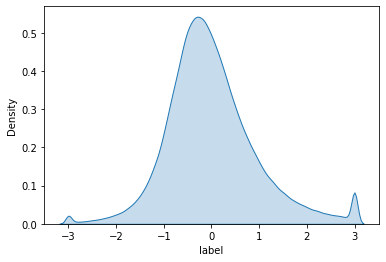

The distribution of y_valid:


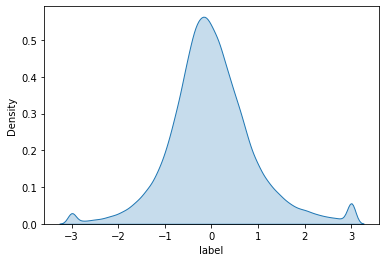

The distribution of y_test:


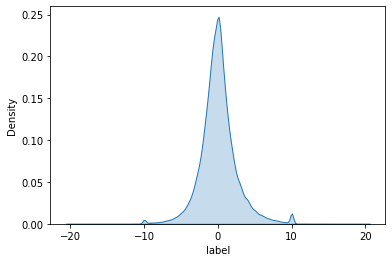

norm data done 

all works done 



In [5]:
split_params = {
    "test_date": "2019-01-01",
    "split_method": "split_by_date",
    "split_kwargs":{
        "train_date": "2016-12-31",
        "valid_date": "2018-12-31"
    }
}

# 从训练集中按7：3的比例随机拆分出验证集, 并在截面上进行标准化
result = q.auto_process(X, "label", groupby="instrument", split_params=split_params, select=False, orth=False)

X_train, y_train, X_valid, y_valid = result["X_train"], result["y_train"], result["X_valid"], result["y_valid"]
X_test, y_test, ymean, ystd = result["X_test"], result["y_test"], result["ymean"], result["ystd"]

In [6]:
# 查看数据处理的结果
X_train.describe()

,RET1_1,RET2_1,RET1_2,RET2_2,RET1_3,RET2_3,RET1_4,RET2_4,CLOSE5,ROC5,...,MEAN2_5,MEAN2_10,MEAN2_20,MEAN2_30,MEAN2_60,AMOUNT5,AMOUNT10,AMOUNT20,AMOUNT30,AMOUNT60
count,726248.000000,7.262480e+05,726248.000000,7.262480e+05,726248.000000,726248.000000,726248.000000,726248.000000,726248.000000,726248.000000,...,726248.000000,726248.000000,726248.000000,726248.000000,726248.000000,726248.000000,726248.000000,726248.000000,726248.000000,726248.000000
mean,-0.002208,2.053049e-07,-0.007458,4.243792e-07,-0.010465,0.000006,-0.012412,0.000005,-0.013791,0.004885,...,-0.014036,-0.017781,-0.019730,-0.020336,-0.018963,-0.021502,-0.024018,-0.026621,-0.028133,-0.030031
std,0.894972,9.981963e-01,0.874542,9.981959e-01,0.863858,0.998200,0.857361,0.998194,0.854553,0.768567,...,0.853862,0.852714,0.862940,0.870911,0.890493,0.878458,0.864680,0.849763,0.839797,0.829464
min,-3.000000,-1.926421e+00,-3.000000,-1.863900e+00,-3.000000,-1.966210,-3.000000,-1.914478,-3.000000,-3.000000,...,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-2.591190,-2.352339,-2.081704,-1.824824
25%,-0.432561,-8.645192e-01,-0.432937,-8.641985e-01,-0.433081,-0.863851,-0.435258,-0.864074,-0.438987,-0.325197,...,-0.439102,-0.459285,-0.488141,-0.507350,-0.536886,-0.597043,-0.593546,-0.589328,-0.582160,-0.575266
50%,0.055554,-7.678854e-16,0.025983,-1.151829e-15,0.016037,-0.000336,0.010680,-0.000218,0.005922,-0.011405,...,0.006152,-0.011692,-0.038020,-0.055473,-0.083626,-0.155242,-0.175656,-0.197836,-0.207857,-0.221962
75%,0.521564,8.643491e-01,0.481299,8.635624e-01,0.461925,0.863687,0.451603,0.863057,0.446336,0.301647,...,0.445128,0.435911,0.427386,0.420008,0.414460,0.354829,0.329153,0.303971,0.280702,0.259587
max,3.000000,2.369545e+00,3.000000,2.878880e+00,3.000000,2.391398,3.000000,2.573271,3.000000,3.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000


In [7]:
# 拟合模型
model = q.auto_lgbm(X_train, y_train, X_valid, y_valid)

pred = model.predict(X_test)
pred = pd.DataFrame(pred, columns=["predict"], index=X_test.index)
pred["predict"] += ymean.groupby("datetime").shift(2).fillna(0.0002)  # 为防止数据泄露, 使用滞后2阶的mean和std还原预测值
pred["predict"] *= ystd.groupby("datetime").shift(2).fillna(0.0189)
pred.describe()

Training until validation scores don't improve for 30 rounds
[20]	train's l2: 0.884896	valid's l2: 0.856785
[40]	train's l2: 0.882326	valid's l2: 0.85624
[60]	train's l2: 0.880544	valid's l2: 0.855925
[80]	train's l2: 0.878955	valid's l2: 0.855635
[100]	train's l2: 0.87762	valid's l2: 0.855413
[120]	train's l2: 0.876335	valid's l2: 0.855228
[140]	train's l2: 0.875128	valid's l2: 0.855052
[160]	train's l2: 0.874044	valid's l2: 0.854904
[180]	train's l2: 0.873014	valid's l2: 0.854804
[200]	train's l2: 0.87196	valid's l2: 0.854706
[220]	train's l2: 0.870854	valid's l2: 0.854603
[240]	train's l2: 0.869919	valid's l2: 0.854541
[260]	train's l2: 0.868972	valid's l2: 0.854483
[280]	train's l2: 0.867997	valid's l2: 0.854423
[300]	train's l2: 0.86706	valid's l2: 0.854423
[320]	train's l2: 0.866123	valid's l2: 0.854452
Early stopping, best iteration is:
[298]	train's l2: 0.867141	valid's l2: 0.854412


,predict
count,280721.000000
mean,-0.000175
std,0.001498
min,-0.008076
25%,-0.001035
50%,-0.000128
75%,0.000724
max,0.008722


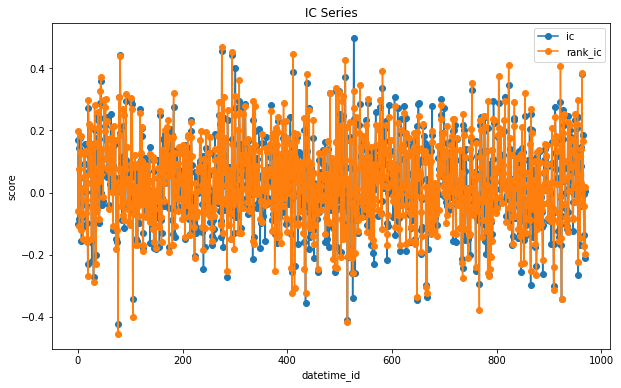

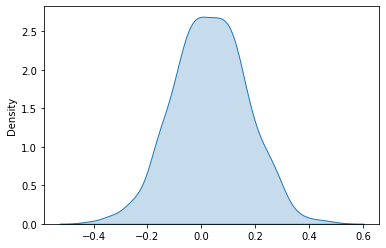

ic= 0.03195637671587498 icir= 0.2314001647535867 rank_ic= 0.03586459188727779 rank_icir= 0.25503011283997307


0.028269426661840062

In [8]:
# 使用IC评判拟合优度
ic, icir, rank_ic, rank_icir = q.ic_ana(pred, y_test, groupby='datetime')
print('ic=', ic, 'icir=', icir, 'rank_ic=', rank_ic, 'rank_icir=', rank_icir)
# 使用pearson相关系数评判拟合优度
r = q.pearson_corr(pred["predict"], y_test)
r

In [9]:
# 以下为回测部分
# 将预测值处理成回测需要的格式(需要知道预测值"predict", 交易价格price和交易量volume)
df_test = df[df.index.get_level_values(0) >= "2019-01-01"]
pred = executor.prepare(pred, df_test, price='mean_price', volume='vol')

Accuracy of Prediction: 0.5285459936417773


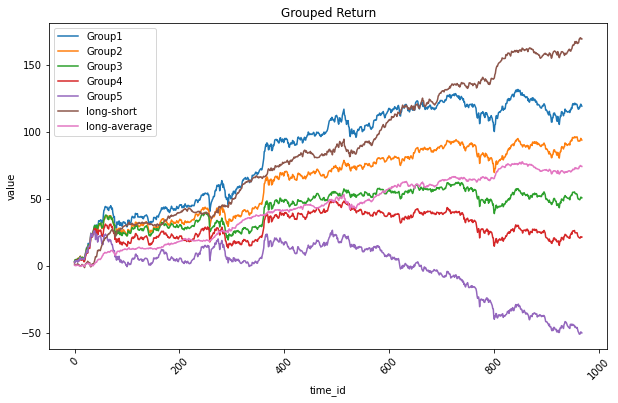

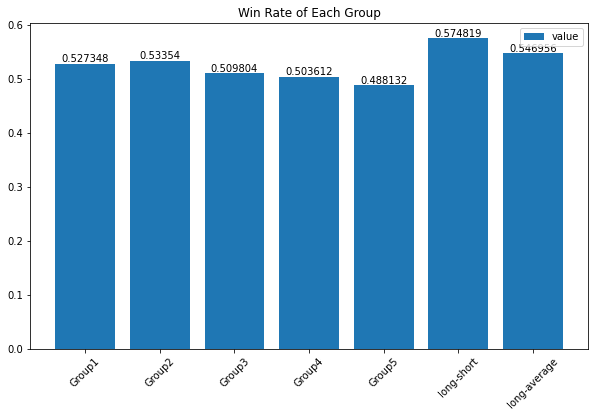

In [10]:
# 如果出现明显的分层, 则说明因子有良好的选股能力
report.group_return_ana(pred, y_test)

In [11]:
backtest = {
    "generator": {
        "mode": "generate"
    },
    "strategy": {
        "class": "TopKStrategy",  # 做多预测值前20%股票, 做空后20%的股票. 自动平仓
        "kwargs": {
            "auto_offset": False,
            "offset_freq": 2, # 应为delta_t + 1, 例如目标值是close_-2 / close_-1 - 1, 则delta_t = 1
            "buy_only": False,  # =True时，只做多不做空(在A股做空有一定的难度)
            "short_volume": 500, # 融券做空的数量
            "risk_degree": 0.95,  # 将风险度控制在这个数，如果超过了就按比例减持股票直到风险度小于等于它为止
            "unit": None,  # 由于数据已经是以手为单位, 故无需二次处理
            "max_volume": 0.25  # 手数随可用资金而改变，最大不会超过股票当天成交量的1%(例如T+1时下单，下单手数不会超过T时成交量的1%)
        }
    },
    "account": None,  # 使用默认账户, 即初始资金为1亿, 无底仓
    "trade_params": {
        "cost_buy": 0.0015,  # 佣金加上印花税
        "cost_sell": 0.0015,  
        "min_cost": 5,
    }
}
generator, strategy, account, trade_params = backtest["generator"], backtest["strategy"], backtest["account"], backtest["trade_params"]
exe = executor.Executor(generator, strategy, account, trade_params)
exe.execute(data=pred, verbose=0)  # verbose=1时，按时间输出买卖指令

Annualized Return: 0.09899653741634018
Annualized Volatility: 0.28316232401261165
Annualized Return(Benchmark): 0.07899686073853784
Annualized Volatility(Benchmark): 0.3390023870788162 

Cumulative Rate of Return: 0.43760848441481226
Cumulative Rate of Return(Benchmark): 0.33958556303554865
Cumulative Excess Rate of Return: 0.0980229213792636 

Max Drawdown: -0.253577151009424
Max Drawdown(Benchmark): -0.5462600364770351 

Sharpe Ratio: 1.993762459640921
Sortino Ratio: -0.8896841205435013
Information Ratio: -0.876520924324451 

Beta: 0.6833757464753757
Alpha: 0.0046870048094370675
Epsilon: 0.08303432831955729
Profitable Days(%): 0.13209494324045407


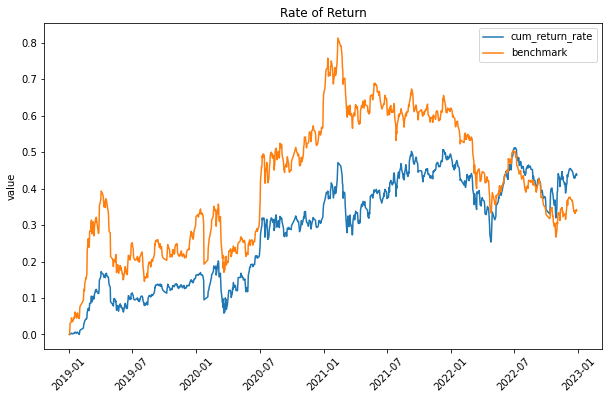

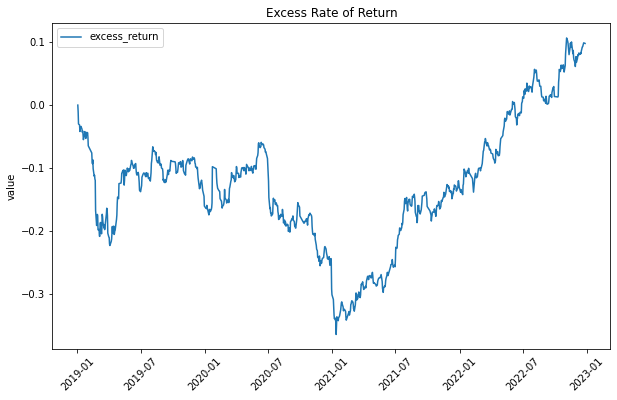

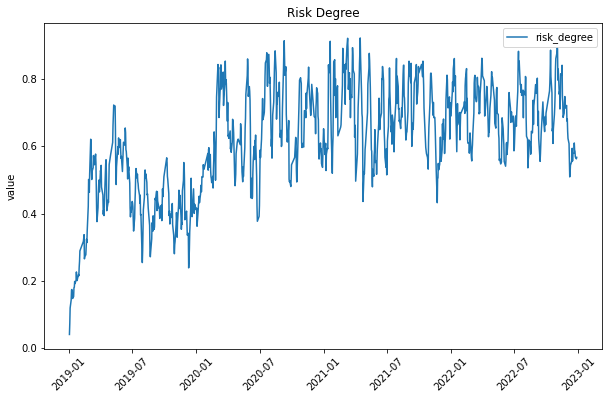

In [12]:
# 报告回测结果
user_account, benchmark = exe.user_account, exe.benchmark
report.report_all(user_account, benchmark, freq=365, time=exe.time)  # 无风险收益率默认为年化3%，可以通过参数rf调节

In [13]:
# user_account.buy_hist # 查看历史上所有买单